# Project Assignment

See the [README.md](https://github.com/anderslaunerbaek/anderslaunerbaek.github.io/blob/master/README.md) for supplementary information.
* [link to video](https://vimeo.com/216286253)
* [link to d3 home page](https://anderslaunerbaek.github.io)
* [link to GIT repo](https://github.com/anderslaunerbaek/anderslaunerbaek.github.io)
* [link to accident data](https://drive.google.com/open?id=0B42GL3RvQcSCWmNSMUxXazFrajQ)
* [link to weather data](https://drive.google.com/open?id=0B42GL3RvQcSCVWotQThvS3ZYcGM)

## 1. Motivation
- What is your dataset?
    - The primary data set is: NYPD Motor Vehicle Collisions [4]. This data contain recorded accidents in New York City. 
    - The secondary data set is: NOAA Climate Data Online weather data of New York City [6].
    - See further descriptions of the two data sets on the [web page](https://anderslaunerbaek.github.io) in the "About the Data" tab.

- Why did you choose this/these particular dataset(s)?
    - The choise of data set is done by personal matter. New York City is a fascination city which never sleeps and there are a lot going on all the time. Despiste that NYC has a dense traffic situation which unfortunately causes accidents. Finding a course of actions of lowering the amount of accidents in NYC could be nice to obtain.
    
- What was your goal for the end user's experience?
    - The number one UX goal is that the webpage is intuitiv and the reader are able to interact with the data.
    - Beside this the visulatizations will have as little ink as possible, combined with a smooth layout.





In [2]:
# Used libraries
from __future__ import division
import json
import numpy as np
import pandas as pd
import datetime as dt
import gmplot
import random
import matplotlib.pyplot as plt
import collections 
from sklearn import cross_validation, tree, neighbors
from statsmodels.tsa.seasonal import seasonal_decompose

### Self defined functions

In [3]:
# Create JSON function 
def createJSON(my_dict, file_name):
    with open(file_name, 'w') as outfile:
        json.dump(my_dict, outfile)
        outfile.close()
        
# load JSON function 
def loadJSON(file_name):
    with open(file_name) as json_file:    
        par = json.load(json_file)
        json_file.close()
    return par

In [4]:
# Create geojson
def parseJson(year,file_name):
    # number of obs. 
    tmp_DF = raw_DF[raw_DF["YEAR"] == year]
    #
    tmp_lat = list(tmp_DF["LATITUDE"])
    tmp_lon = list(tmp_DF["LONGITUDE"])
    tmp_hour = list(tmp_DF["HOUR"])
    tmp_borough = list(tmp_DF["BOROUGH"])
    # 
    N_tot = len(tmp_lat)
    
    # output
    out_dict = [{'lat': tmp_lat[ii],
                 'lon': tmp_lon[ii],
                 'r': 1} for ii in range(0,N_tot)]
    #
    createJSON(out_dict, file_name) 

In [5]:
# function to turn decision tree into a json file [2]
def rules(clf, features, labels, node_index=0):
    """Structure of rules in a fit decision tree classifier
    Parameters
    ----------
    clf : DecisionTreeClassifier
        A tree that has already been fit.

    features, labels : lists of str
        The names of the features and labels, respectively.
    """
    node = {}
    if clf.tree_.children_left[node_index] == -1:  # indicates leaf
        count_labels = zip(clf.tree_.value[node_index, 0], labels)
        node['name'] = ', '.join(('{} of {}'.format(int(count), label)
                                  for count, label in count_labels))
    else:
        feature = features[clf.tree_.feature[node_index]]
        threshold = clf.tree_.threshold[node_index]
        node['name'] = '{} > {}'.format(feature, threshold)
        left_index = clf.tree_.children_left[node_index]
        right_index = clf.tree_.children_right[node_index]
        node['children'] = [rules(clf, features, labels, right_index),
                            rules(clf, features, labels, left_index)]
    return node

## 2. Let's Understand the Data set Better     
- Cleaning:
    - It has been chosen to set filters and hereby "pre-clean" the data before downloading the files from NYPD MVC Data [4]. 
    - The raw data set includes following filters:
         - Date between 01/01/2013 and 12/31/2016. It has been chosen to have four full years of observations. 
         - BOROUGH, LATITUDE and LONGITUDE must not be "na":
         - The three above filters exclude roughly 30% of the data from the given period but GEO-location is required in this project.
    - Six used features have been removed in the code block below.
    - Setting the filter prior to download of data maens that the data wrangeling time have been used in the preprocessing.
- Preprocessing:
    - In the preprocessing part there has been made five extra features based upon the data set, which are used later on.



In [6]:
# Load data
raw_DF = pd.read_csv("data/raw_data.csv", low_memory = False)

# Getting year
year = raw_DF["DATE"].apply(lambda x: x.split('/'))
raw_DF["YEAR"] = year.apply(lambda x: int(x[2]))

# Getting hour
hour = raw_DF["TIME"].apply(lambda x: x.split(':'))
raw_DF["HOUR"] = hour.apply(lambda x: int(x[0]))
raw_DF["TIME_DEC"] = hour.apply(lambda x: float(int(x[0]) + int(x[1])/60) )

# Getting month
month = raw_DF["DATE"].apply(lambda x: x.split('/'))
raw_DF["MONTH"] = month.apply(lambda x: int(x[0]))

# create bool variable KNN_bool = [0, 1, 2, 3]. 
# 0 if persons not are injured nor killed
raw_DF['KNN_DTree'] = 0
# 1 if persons are injured
tmp_idx = list(raw_DF[raw_DF['NUMBER OF PERSONS INJURED'] > 0].index)
raw_DF.loc[tmp_idx,'KNN_DTree'] = 1
# 2 if persons are killed
tmp_idx = list(raw_DF[raw_DF['NUMBER OF PERSONS KILLED'] > 0].index)
raw_DF.loc[tmp_idx,'KNN_DTree'] = 2
# 3 if persons are injured and killed
tmp_idx = list(raw_DF[(raw_DF['NUMBER OF PERSONS INJURED'] > 0) & 
                      (raw_DF['NUMBER OF PERSONS KILLED'] > 0)].index)
raw_DF.loc[tmp_idx,'KNN_DTree'] = 3

# Remove unused columns
raw_DF = raw_DF.drop(['ZIP CODE',
                      'LOCATION',
                      'UNIQUE KEY',
                      'ON STREET NAME',
                      'CROSS STREET NAME',
                      'OFF STREET NAME'], axis = 1)
#print "DF shape: ", raw_DF.shape
N = raw_DF.shape[0]

### The Statistic of the Data set 

In [7]:
# dict. to capture information
pra_info = {}

# Unique days in data set
pra_info['unique days'] = list(set(raw_DF['DATE']))

# First day of observations
pra_info['first obs'] = min(raw_DF["DATE"])

# Last day of observations
pra_info['last obs'] = max(raw_DF["DATE"])
print 'First day:', pra_info['first obs'], 'and last day:', pra_info['last obs'], 'in data.\n'

# Unique years in data set
pra_info['unique year'] = sorted(list(set(raw_DF['YEAR'])))
print 'Unique years:', pra_info['unique year'], '\n'

# number of accidents each year
pra_info['N'] = {}
tmp_year = 0
for ii in pra_info['unique year']:
    pra_info['N'][ii] = len(raw_DF[raw_DF['YEAR'] == ii])
    tmp_year += pra_info['N'][ii]
pra_info['N']['tot'] = tmp_year
print 'Number of accidents each year:\n',pra_info['N'], '\n'

# Unique borough
pra_info['unique borough'] = list(set(raw_DF['BOROUGH']))
print 'Unique borough in NYC:', pra_info['unique borough'], '\n'

# Sum accidents in borough for each year
pra_info['borough'] = {}
for ii in pra_info['unique borough']:
    pra_info['borough'][ii] = {}
    tmp_year = 0
    for jj in pra_info['unique year']:
        pra_info['borough'][ii][jj] = len(raw_DF[(raw_DF['YEAR'] == jj) & (raw_DF['BOROUGH'] == ii)])
        tmp_year += pra_info['borough'][ii][jj]
    # sum total accidents in borough each year
    pra_info['borough'][ii]['tot'] = tmp_year
    
print 'Accidents in borough for each year:'
for ii in pra_info['unique borough']:
    print '{0}: {1}'.format(ii,pra_info['borough'][ii])

# Ratios of accidents in borough for each year
pra_info['ratio'] = {}
pra_info['ratio_p'] = {} # for print
print '\nRatio of accidents in borough for each year in (%):'
for ii in pra_info['unique borough']:
    pra_info['ratio'][ii] = {}
    pra_info['ratio_p'][ii] = {}
    for jj in pra_info['unique year'] + ['tot']:
        pra_info['ratio'][ii][jj] = pra_info['borough'][ii][jj] / pra_info['N'][jj]
        pra_info['ratio_p'][ii][jj] = float('{0:.2f}'.format(pra_info['ratio'][ii][jj] * 100))
    # print   
    print '{0}: {1}'.format(ii, pra_info['ratio_p'][ii])    

# Accidents per day
pra_info['No. day'] = {}
for ii in pra_info['unique days']:
    pra_info['No. day'][ii] = len(raw_DF[raw_DF['DATE'] == ii])
    
# counting
tmp_years = [int(pra_info['No. day'].keys()[ii].split('/')[2]) for ii in range(len(pra_info['No. day']))]
tmp_days = collections.Counter(tmp_years)
tmp_days['tot'] = len(pra_info['No. day'])

pra_info['avg day'] = {}
pra_info['avg day_p'] = {} # for printing
for ii in pra_info['unique year'] + ['tot']:
    pra_info['avg day'][ii] = pra_info['N'][ii] / tmp_days[ii]
    pra_info['avg day_p'][ii] = float('{0:.2f}'.format(pra_info['avg day'][ii]))
print '\nAverage accidents per day for each year:\n', pra_info['avg day_p']
# Average per year
pra_info['avg year'] = {}
pra_info['avg year_p'] = {} # for pringting
for ii in pra_info['unique year'] + ['tot']:
    pra_info['avg year'][ii] =  pra_info['N'][ii] / len(pra_info['unique year'])
    pra_info['avg year_p'][ii] = float('{0:.2f}'.format(pra_info['avg year'][ii]))
print '\nAverage accidents per year for each year:\n',pra_info['avg year_p']

# Maximum and Minimum accidents per day
print "\nDay with most accidents"
print sorted(pra_info['No. day'].items(), key=lambda x: x[1], reverse=True)[0]
print "\nDay with least accidents"

print sorted(pra_info['No. day'].items(), key=lambda x: x[1], reverse=False)[0]

print "\nTop 10 days with most accidents:" 
print sorted(pra_info['No. day'].items(), key=lambda x: x[1], reverse=True)[0:10]

print "\nTop 10 days with least accidents:" 
print sorted(pra_info['No. day'].items(), key=lambda x: x[1], reverse=False)[0:10]

First day: 01/01/2013 and last day: 12/31/2016 in data.

Unique years: [2013, 2014, 2015, 2016] 

Number of accidents each year:
{2016: 125645, 'tot': 601313, 2013: 155958, 2014: 156293, 2015: 163417} 

Unique borough in NYC: ['BRONX', 'BROOKLYN', 'STATEN ISLAND', 'MANHATTAN', 'QUEENS'] 

Accidents in borough for each year:
BRONX: {2016: 17482, 'tot': 78176, 2013: 19766, 2014: 19680, 2015: 21248}
BROOKLYN: {2016: 39032, 'tot': 184622, 2013: 47011, 2014: 47745, 2015: 50834}
STATEN ISLAND: {2016: 5519, 'tot': 26770, 2013: 8295, 2014: 6613, 2015: 6343}
MANHATTAN: {2016: 30448, 'tot': 155788, 2013: 41578, 2014: 41249, 2015: 42513}
QUEENS: {2016: 33164, 'tot': 155957, 2013: 39308, 2014: 41006, 2015: 42479}

Ratio of accidents in borough for each year in (%):
BRONX: {2016: 13.91, 'tot': 13.0, 2013: 12.67, 2014: 12.59, 2015: 13.0}
BROOKLYN: {2016: 31.07, 'tot': 30.7, 2013: 30.14, 2014: 30.55, 2015: 31.11}
STATEN ISLAND: {2016: 4.39, 'tot': 4.45, 2013: 5.32, 2014: 4.23, 2015: 3.88}
MANHATTAN: 

- The overall trend of accidents are decreasing during the four year period.
- Brooklyn has the majority of the accidents despite the heat-map is "warmer" on Manhatten.
- The majority of the top ten accidents are in the winter months.

The KNN_Dtree feature contain information regarding which classe of accidents each observation has.
- 0 if person(s) not is injured nor killed in an accident
- 1 if person(s) is injured in an accident
- 2 if person(s) are killed in an accident
- 3 if persons are injured and killed in an accident
In the following output it is possible to see the distrution of the classes:

In [8]:
print collections.Counter(raw_DF['KNN_DTree'])

Counter({0: 489592, 1: 111082, 2: 493, 3: 146})


and clearly seen, there are a non-balanced distrution among the classes. This may have an impact on the prediction tools described later. 

## 3. Which theoretical tools did you use?
- Describe which machine learning tools you use and why the tools you've chosen are right for the problem you're solving.
    - In the predictive modelling following methods are in this project:
        - Seasonal decomposition from the statsmodels library
        - K-Nearest Neighbors from the sklearn library
        - Decision tree from the sklearn library
    - The first one is used because it has an easy interface and return understandable output.
    - The last to models are used because they are reletively easy to explain to a non technical person. 
- Talk about your model selection.
    - K-10-fold have been used to learn and optimize the values of the KNN and the decision tree. In the ideal world the the leave one out methods are is the best, but with respect to computation time the 10-fold is a great compromise.
- Explain the model performance.
    - The measure of classification are done by comparing the estimated class based on the features of the test data with the class of the test data.
    - The performance of the KKN algorithm are as expected due to the non balaced distribution of the classes.
    - The performance of the decision tree is better than the KNN as sexpected. 
    - Forthe random samlpes the decision tree are much better fit initial distrubtion. Of cause the predictions have been made on random samlpe data with no correct class label. But in theory, the prediction of the classes should follow the inital distribution of the classes.

## 4. Visualizations
- Explain the visualizations you've chosen.
    - At the welcome screen there is interactive heat-map delevoped in gmplot. It works good in html and it is possible to zoom, drag, ect.
    - Simple bar plot, because it is very suitable to get an understanding of the distribution of the data. In this cases it plots the frequencies of accidents for a given time slot. And it is possible to select the four different versions for each borough.
    - Interactive time serie plot which tells a lot of the seasonality accidents.
    - KNN plot which shows the predicted classes. It can show the locations of the clusters of classes. Of cause it could be nice to illustrate all four feature, but only the location is possible.
    - A decision tree because it is a nice interactive plot. By visualizing the tree is it easy to get an understanding of the splits and the importances of each feature.

### Intro plot

In [9]:
# Heat Map
# Manually insetting API key and the accidents coordinates
## gmap = gmplot.GoogleMapPlotter(np.mean(raw_DF["LATITUDE"]), np.mean(raw_DF["LONGITUDE"]), 10.5)
## gmap.heatmap(list(raw_DF["LATITUDE"]), list(raw_DF["LONGITUDE"]), threshold=5, radius=5)
## gmap.draw("data/heatmap.html")

# decrease obs 
idx = (raw_DF.sample(frac=0.5).index)

# dict with coordinates
coor = {}
coor['lon'] = list(raw_DF["LONGITUDE"].iloc[idx])
coor['lat'] = list(raw_DF["LATITUDE"].iloc[idx])
coor['N'] = len(idx)
# write to file for later copy paste.
f = open('data/heatmap.txt', 'w')
[f.write('new google.maps.LatLng({0},{1}),\n'.format(coor['lat'][ii],coor['lon'][ii])) for ii in range(coor['N'])]
f.close() 

### Bar plot
This one creates the jsons for alle the bar plots.

In [10]:
# Time frame
tmp_x_key = ["00:00-00:59","01:00-01:59","02:00-02:59","03:00-03:59","04:00-04:59","05:00-05:59",
             "06:00-06:59","07:00-07:59","08:00-08:59","09:00-09:59","10:00-10:59","11:00-11:59",
             "12:00-12:59","13:00-13:59","14:00-14:59","15:00-15:59","16:00-16:59","17:00-17:59",
             "18:00-18:59","19:00-19:59","20:00-20:59","21:00-21:59","22:00-22:59","23:00-23:59"]

# Init lists
bar_dict_NYC = []
bar_dict_BRONX = []
bar_dict_BROOKLYN = []
bar_dict_STATEN_ISLAND = []
bar_dict_MANHATTAN = []
bar_dict_QUEENS = []
# Non injured or killed
bar_dict_NYC_non = []
bar_dict_BRONX_non = []
bar_dict_BROOKLYN_non = []
bar_dict_STATEN_ISLAND_non = []
bar_dict_MANHATTAN_non = []
bar_dict_QUEENS_non = []
# Injured
bar_dict_NYC_inj = []
bar_dict_BRONX_inj = []
bar_dict_BROOKLYN_inj = []
bar_dict_STATEN_ISLAND_inj = []
bar_dict_MANHATTAN_inj = []
bar_dict_QUEENS_inj = []
# Killed
bar_dict_NYC_kill = []
bar_dict_BRONX_kill = []
bar_dict_BROOKLYN_kill = []
bar_dict_STATEN_ISLAND_kill = []
bar_dict_MANHATTAN_kill = []
bar_dict_QUEENS_kill = []

# Loop through each time frame
for ii in range(0,24):
    tmp_borough = {}
    tmp_borough_non = {}
    tmp_borough_inj = {}
    tmp_borough_kill = {}
    # Loop each borough
    for jj in pra_info['unique borough']:
        # Get number of accidents for each time frame in each borough
        tmp_borough[jj] = len(raw_DF[(raw_DF['BOROUGH'] == jj) & 
                                     (raw_DF['HOUR'] == ii)])
        # -||- with no persons injured or killed
        tmp_borough_non[jj] = len(raw_DF[(raw_DF['BOROUGH'] == jj) & 
                                         (raw_DF['HOUR'] == ii) & 
                                         (raw_DF['NUMBER OF PERSONS INJURED'] == 0) & 
                                         (raw_DF['NUMBER OF PERSONS KILLED'] == 0)])
        # -||- with persons injured
        tmp_borough_inj[jj] = len(raw_DF[(raw_DF['BOROUGH'] == jj) & 
                                         (raw_DF['HOUR'] == ii) & 
                                         (raw_DF['NUMBER OF PERSONS INJURED'] > 0)])
        # -||- with persons killed
        tmp_borough_kill[jj] = len(raw_DF[(raw_DF['BOROUGH'] == jj) & 
                                          (raw_DF['HOUR'] == ii) & 
                                          (raw_DF['NUMBER OF PERSONS KILLED'] > 0)])
        
    # Sum all for given time slot
    tmp_sum = np.sum(tmp_borough.values())
    tmp_sum_non = np.sum(tmp_borough_non.values())
    tmp_sum_inj = np.sum(tmp_borough_inj.values())
    tmp_sum_kill = np.sum(tmp_borough_kill.values())
    
    # Append time slot to list
    bar_dict_NYC.append({'key': tmp_x_key[ii], 'value': tmp_sum})
    bar_dict_BRONX.append({'key': tmp_x_key[ii], 'value': tmp_borough['BRONX']})
    bar_dict_BROOKLYN.append({'key': tmp_x_key[ii], 'value': tmp_borough['BROOKLYN']})
    bar_dict_STATEN_ISLAND.append({'key': tmp_x_key[ii], 'value': tmp_borough['STATEN ISLAND']})
    bar_dict_MANHATTAN.append({'key': tmp_x_key[ii], 'value': tmp_borough['MANHATTAN']})
    bar_dict_QUEENS.append({'key': tmp_x_key[ii], 'value': tmp_borough['QUEENS']})
    
    # Non injured or killed
    bar_dict_NYC_non.append({'key': tmp_x_key[ii], 'value': tmp_sum_non})
    bar_dict_BRONX_non.append({'key': tmp_x_key[ii], 'value': tmp_borough_non['BRONX']})
    bar_dict_BROOKLYN_non.append({'key': tmp_x_key[ii], 'value': tmp_borough_non['BROOKLYN']})
    bar_dict_STATEN_ISLAND_non.append({'key': tmp_x_key[ii], 'value': tmp_borough_non['STATEN ISLAND']})
    bar_dict_MANHATTAN_non.append({'key': tmp_x_key[ii], 'value': tmp_borough_non['MANHATTAN']})
    bar_dict_QUEENS_non.append({'key': tmp_x_key[ii], 'value': tmp_borough_non['QUEENS']})
    
    # Injured
    bar_dict_NYC_inj.append({'key': tmp_x_key[ii], 'value': tmp_sum_inj})
    bar_dict_BRONX_inj.append({'key': tmp_x_key[ii], 'value': tmp_borough_inj['BRONX']})
    bar_dict_BROOKLYN_inj.append({'key': tmp_x_key[ii], 'value': tmp_borough_inj['BROOKLYN']})
    bar_dict_STATEN_ISLAND_inj.append({'key': tmp_x_key[ii], 'value': tmp_borough_inj['STATEN ISLAND']})
    bar_dict_MANHATTAN_inj.append({'key': tmp_x_key[ii], 'value': tmp_borough_inj['MANHATTAN']})
    bar_dict_QUEENS_inj.append({'key': tmp_x_key[ii], 'value': tmp_borough_inj['QUEENS']})
    
    # Killed
    bar_dict_NYC_kill.append({'key': tmp_x_key[ii], 'value': tmp_sum_kill})
    bar_dict_BRONX_kill.append({'key': tmp_x_key[ii], 'value': tmp_borough_kill['BRONX']})
    bar_dict_BROOKLYN_kill.append({'key': tmp_x_key[ii], 'value': tmp_borough_kill['BROOKLYN']})
    bar_dict_STATEN_ISLAND_kill.append({'key': tmp_x_key[ii], 'value': tmp_borough_kill['STATEN ISLAND']})
    bar_dict_MANHATTAN_kill.append({'key': tmp_x_key[ii], 'value': tmp_borough_kill['MANHATTAN']})
    bar_dict_QUEENS_kill.append({'key': tmp_x_key[ii], 'value': tmp_borough_kill['QUEENS']})
    
# Create json for bar plots 
createJSON(bar_dict_NYC, 'data/bar/bar_dict_NYC.json')
createJSON(bar_dict_BRONX, 'data/bar/bar_dict_BRONX.json')
createJSON(bar_dict_BROOKLYN, 'data/bar/bar_dict_BROOKLYN.json')
createJSON(bar_dict_STATEN_ISLAND, 'data/bar/bar_dict_STATEN_ISLAND.json')
createJSON(bar_dict_MANHATTAN, 'data/bar/bar_dict_MANHATTAN.json')
createJSON(bar_dict_QUEENS, 'data/bar/bar_dict_QUEENS.json')

createJSON(bar_dict_NYC_non, 'data/bar/bar_dict_NYC_non.json')
createJSON(bar_dict_BRONX_non, 'data/bar/bar_dict_BRONX_non.json')
createJSON(bar_dict_BROOKLYN_non, 'data/bar/bar_dict_BROOKLYN_non.json')
createJSON(bar_dict_STATEN_ISLAND_non, 'data/bar/bar_dict_STATEN_ISLAND_non.json')
createJSON(bar_dict_MANHATTAN_non, 'data/bar/bar_dict_MANHATTAN_non.json')
createJSON(bar_dict_QUEENS_non, 'data/bar/bar_dict_QUEENS_non.json')

createJSON(bar_dict_NYC_inj, 'data/bar/bar_dict_NYC_inj.json')
createJSON(bar_dict_BRONX_inj, 'data/bar/bar_dict_BRONX_inj.json')
createJSON(bar_dict_BROOKLYN_inj, 'data/bar/bar_dict_BROOKLYN_inj.json')
createJSON(bar_dict_STATEN_ISLAND_inj, 'data/bar/bar_dict_STATEN_ISLAND_inj.json')
createJSON(bar_dict_MANHATTAN_inj, 'data/bar/bar_dict_MANHATTAN_inj.json')
createJSON(bar_dict_QUEENS_inj, 'data/bar/bar_dict_QUEENS_inj.json')

createJSON(bar_dict_NYC_kill, 'data/bar/bar_dict_NYC_kill.json')
createJSON(bar_dict_BRONX_kill, 'data/bar/bar_dict_BRONX_kill.json')
createJSON(bar_dict_BROOKLYN_kill, 'data/bar/bar_dict_BROOKLYN_kill.json')
createJSON(bar_dict_STATEN_ISLAND_kill, 'data/bar/bar_dict_STATEN_ISLAND_kill.json')
createJSON(bar_dict_MANHATTAN_kill, 'data/bar/bar_dict_MANHATTAN_kill.json')
createJSON(bar_dict_QUEENS_kill, 'data/bar/bar_dict_QUEENS_kill.json')

### Time Series
This one creates the jsons for alle the bar plots.

In [11]:
# Time Series
ts_json_ped = []; ts_json_cyc = []; ts_json_mot = []; ts_json_NYC = []

# Loop for each day
for dd in pra_info['unique days']:
    # Init temp dict.
    tmp_ped = {}
    tmp_cyc = {}
    tmp_mot = {}
    
    # Init dict level for NYC
    tmp_ped['NYC'] = {}; tmp_cyc['NYC'] = {}; tmp_mot['NYC'] = {}

    # Setting date
    tmp_ped['NYC']['date'] = dd; tmp_cyc['NYC']['date'] = dd; tmp_mot['NYC']['date'] = dd
    
    # Init inital value to later sum
    tmp_ped['NYC']['inj'] = 0; tmp_cyc['NYC']['inj'] = 0; tmp_mot['NYC']['inj'] = 0
    tmp_ped['NYC']['kill'] = 0; tmp_cyc['NYC']['kill'] = 0; tmp_mot['NYC']['kill'] = 0
    tmp_ped['NYC']['tot'] = 0; tmp_cyc['NYC']['tot'] = 0; tmp_mot['NYC']['tot'] = 0
    tmp_ped['NYC']['non'] = 0; tmp_cyc['NYC']['non'] = 0; tmp_mot['NYC']['non'] = 0
    # Loop for each borough
    for bb in pra_info['unique borough']:
        # Init dict
        tmp_ped[bb] = {}
        tmp_cyc[bb] = {}
        tmp_mot[bb] = {}
        # Add date
        tmp_ped[bb]['date'] = dd
        tmp_cyc[bb]['date'] = dd
        tmp_mot[bb]['date'] = dd
        # Find indices for unique day and unique borough
        tmp_N = len(raw_DF[(raw_DF['DATE'] == dd) & (raw_DF['BOROUGH'] == bb)])
        
        # Get number of accidents which affects pedestrians
        tmp_ped[bb]['inj'] = len(raw_DF[(raw_DF['DATE'] == dd) & 
                                        (raw_DF['BOROUGH'] == bb) & 
                                        (raw_DF['NUMBER OF PEDESTRIANS INJURED'] > 0)])
        tmp_ped[bb]['kill'] = len(raw_DF[(raw_DF['DATE'] == dd) & 
                                        (raw_DF['BOROUGH'] == bb) & 
                                        (raw_DF['NUMBER OF PEDESTRIANS KILLED'] > 0)])
        tmp_ped[bb]['tot'] = tmp_ped[bb]['inj'] + tmp_ped[bb]['kill']
        # Get number of accidents which not affects pedestrians
        tmp_ped[bb]['non'] = len(raw_DF[(raw_DF['DATE'] == dd) & 
                                        (raw_DF['BOROUGH'] == bb) & 
                                        (raw_DF['NUMBER OF PEDESTRIANS INJURED'] == 0) & 
                                        (raw_DF['NUMBER OF PEDESTRIANS KILLED'] == 0)])
        # Get number of accidents which affects cyclist
        tmp_cyc[bb]['inj'] = len(raw_DF[(raw_DF['DATE'] == dd) & 
                                        (raw_DF['BOROUGH'] == bb) & 
                                        (raw_DF['NUMBER OF CYCLIST INJURED'] > 0)])
        tmp_cyc[bb]['kill'] = len(raw_DF[(raw_DF['DATE'] == dd) & 
                                        (raw_DF['BOROUGH'] == bb) & 
                                        (raw_DF['NUMBER OF CYCLIST KILLED'] > 0)])
        tmp_cyc[bb]['tot'] = tmp_cyc[bb]['inj'] + tmp_cyc[bb]['kill']
        # Get number of accidents which not affects cyclist
        tmp_cyc[bb]['non'] = len(raw_DF[(raw_DF['DATE'] == dd) & 
                                        (raw_DF['BOROUGH'] == bb) & 
                                        (raw_DF['NUMBER OF CYCLIST INJURED'] == 0) & 
                                        (raw_DF['NUMBER OF CYCLIST KILLED'] == 0)])
        # Get number of accidents which affects motorist
        tmp_mot[bb]['inj'] = len(raw_DF[(raw_DF['DATE'] == dd) & 
                                        (raw_DF['BOROUGH'] == bb) & 
                                        (raw_DF['NUMBER OF MOTORIST INJURED'] > 0)])
        tmp_mot[bb]['kill'] = len(raw_DF[(raw_DF['DATE'] == dd) & 
                                        (raw_DF['BOROUGH'] == bb) & 
                                        (raw_DF['NUMBER OF MOTORIST KILLED'] > 0)])
        tmp_mot[bb]['tot'] = tmp_mot[bb]['inj'] + tmp_mot[bb]['kill']
        # Get number of accidents which not affects motorist
        tmp_mot[bb]['non'] = len(raw_DF[(raw_DF['DATE'] == dd) & 
                                        (raw_DF['BOROUGH'] == bb) & 
                                        (raw_DF['NUMBER OF MOTORIST INJURED'] == 0) & 
                                        (raw_DF['NUMBER OF MOTORIST KILLED'] == 0)])
        # Scale to ratios for given borough for given day 
        # Loop each category
        for kk in ['inj', 'kill','non','tot']:
            #
            try: 
                tmp_ped[bb][kk] = tmp_ped[bb][kk] / tmp_N
            except ZeroDivisionError: 
                tmp_ped[bb][kk] = 0
            #
            try: 
                tmp_cyc[bb][kk] = tmp_cyc[bb][kk] / tmp_N
            except ZeroDivisionError: 
                tmp_cyc[bb][kk] = 0         
            #
            try: 
                tmp_mot[bb][kk] = tmp_mot[bb][kk] / tmp_N
            except ZeroDivisionError: 
                tmp_mot[bb][kk] = 0
                
        # end loop        
            
        # Summing to NYC
        tmp_ped['NYC']['non'] += tmp_ped[bb]['non']
        tmp_ped['NYC']['inj'] += tmp_ped[bb]['inj']
        tmp_ped['NYC']['kill'] += tmp_ped[bb]['kill']
        tmp_ped['NYC']['tot'] += tmp_ped[bb]['tot']
        
        tmp_cyc['NYC']['non'] += tmp_cyc[bb]['non']
        tmp_cyc['NYC']['inj'] += tmp_cyc[bb]['inj']
        tmp_cyc['NYC']['kill'] += tmp_cyc[bb]['kill']
        tmp_cyc['NYC']['tot'] += tmp_cyc[bb]['tot']
        
        tmp_mot['NYC']['non'] += tmp_mot[bb]['non']
        tmp_mot['NYC']['inj'] += tmp_mot[bb]['inj']
        tmp_mot['NYC']['kill'] += tmp_mot[bb]['kill']
        tmp_mot['NYC']['tot'] += tmp_mot[bb]['tot']
        
    # Loop 
    for kk in ['inj', 'kill','non','tot']:
        #
        try: 
            tmp_ped['NYC'][kk] = tmp_ped['NYC'][kk] / len(pra_info['unique borough']) 
        except ZeroDivisionError: 
            tmp_ped['NYC'][kk] = 0
        #
        try: 
            tmp_cyc['NYC'][kk] = tmp_cyc['NYC'][kk] / len(pra_info['unique borough']) 
        except ZeroDivisionError: 
            tmp_cyc['NYC'][kk] = 0
        #
        try: 
            tmp_mot['NYC'][kk] = tmp_mot['NYC'][kk] / len(pra_info['unique borough']) 
        except ZeroDivisionError: 
            tmp_mot['NYC'][kk] = 0
    # end loop    
    
    # Append day and info to the json list
    ts_json_ped.append(tmp_ped)
    ts_json_cyc.append(tmp_cyc)
    ts_json_mot.append(tmp_mot)

# Create json data for D3
for bb in pra_info['unique borough'] + ['NYC']:
    # Pedestrians
    tmp = [ts_json_ped[ii][bb] for ii in range(len(ts_json_ped))]
    tmp.sort(key=lambda x: dt.datetime.strptime(x['date'], '%m/%d/%Y'))
    createJSON(tmp,'data/ts/ts_ped_' + bb + '.json')
    # Cyclist
    tmp = [ts_json_cyc[ii][bb] for ii in range(len(ts_json_cyc))]
    tmp.sort(key=lambda x: dt.datetime.strptime(x['date'], '%m/%d/%Y'))
    createJSON(tmp,'data/ts/ts_cyc_' + bb + '.json')
    # Motorist
    tmp = [ts_json_mot[ii][bb] for ii in range(len(ts_json_mot))]
    tmp.sort(key=lambda x: dt.datetime.strptime(x['date'], '%m/%d/%Y'))
    createJSON(tmp,'data/ts/ts_mot_' + bb + '.json')

The function "seasonal_decompose" from "statsmodels.tsa.seasonal" have been used to detect seasonality in the time series. For now it is only interesting if there are any or not persons injured.

The code block below shows an example of:
- Injured PEDESTRIANS
- On MANHATTAN

and maybe more interesting trendencies could be found in other boroughs and types of accidents.

Season of: 1 day(s)


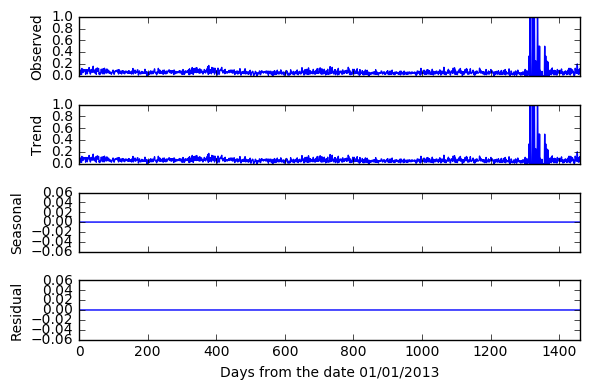

Season of: 7 day(s)


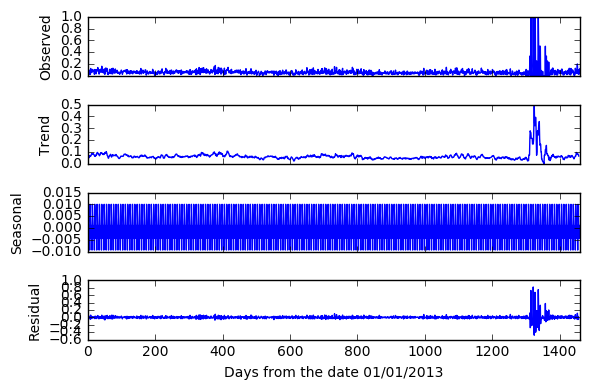

Season of: 30 day(s)


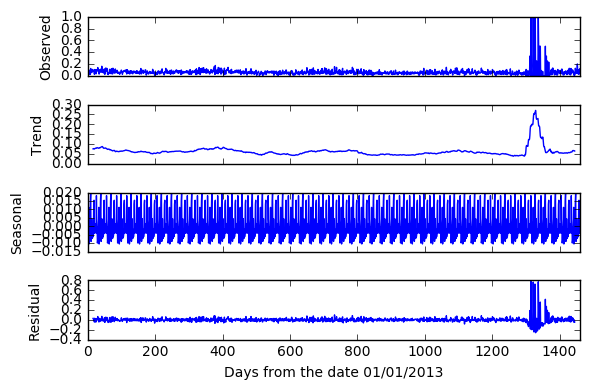

Season of: 365 day(s)


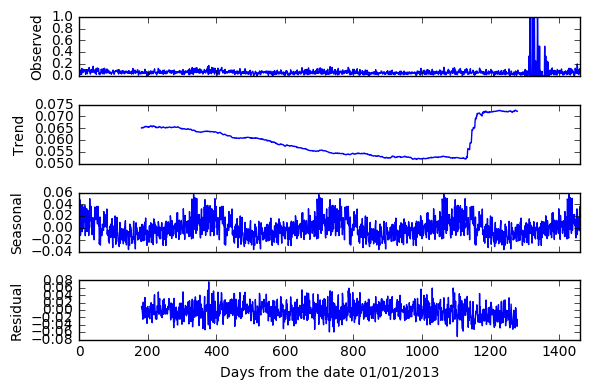

In [12]:
# Load json created above.
Series = loadJSON('data/ts/ts_ped_MANHATTAN.json')
ts_tmp = [Series[ii]['inj'] for ii in range(len(Series))]

# Loop for each season
for ii in [1,7,30,365]:
    print "Season of:", ii, 'day(s)'
    result = seasonal_decompose(ts_tmp, model='additive', freq=ii)
    # plot subplot 
    result.plot()
    # add label
    plt.xlabel("Days from the date 01/01/2013")
    plt.show()
# end loop

By looking at the plot with a season of 365 days, it can bee seen that there are more injured pedestrians in the winter time. Despit the many smaples, the 30 days seasonal looks also uniform.

### KNN

The KKN is the first prediction tool. Selection of feature for the predicting tool are:
- GEO-location
- Time of day
- Month of year

They are selected because it is resoable to provide this information which an accident occur.

The first code return the statistic distribution of the four classes and creates a a common dictionary for KNN and DTree.

In [13]:
# Create dict for prediction tool
knn_dtree_dict = {}
knn_dtree_dict['lat'] = list(raw_DF['LATITUDE'])
knn_dtree_dict['lon'] = list(raw_DF['LONGITUDE'])
knn_dtree_dict['time'] = list(raw_DF['TIME_DEC'])
knn_dtree_dict['month'] = list(raw_DF['MONTH'])
knn_dtree_dict['class'] = list(raw_DF['KNN_DTree'])
knn_dtree_dict['N'] = len(knn_dtree_dict['class'])

# For prediction 
knn_dtree_dict['features'] = ['LATITUDE', 'LONGITUDE', 'TIME_DEC', 'MONTH']
knn_dtree_dict['target_names'] = ['Non injured nor killed', 'Injured', 'Killed', 'Injured or killed']
knn_dtree_dict['X'] = np.array([[knn_dtree_dict['lat'][ii], 
                                 knn_dtree_dict['lon'][ii], 
                                 knn_dtree_dict['time'][ii], 
                                 knn_dtree_dict['month'][ii]] for ii in range(knn_dtree_dict['N'])])
knn_dtree_dict['y'] = np.array([knn_dtree_dict['class'][ii] for ii in range(knn_dtree_dict['N'])])

# Create knn_json for D3
knn_json = [{'lat': knn_dtree_dict['lat'][ii],
             'lon': knn_dtree_dict['lon'][ii],
             'class': knn_dtree_dict['class'][ii]} for ii in range(len(knn_dtree_dict['class']))]
createJSON(knn_json, 'data/knn/knn_json.json') 

# 
tmp = collections.Counter(knn_dtree_dict['class'])
print 'Non injured nor killed: {0:.3f}% ~ {1}'.format(tmp.values()[0] / np.sum(tmp.values()) * 100,tmp.values()[0])
print 'Injured:                {0:.3f}% ~ {1}'.format(tmp.values()[1] / np.sum(tmp.values()) * 100,tmp.values()[1])
print 'Killed:                  {0:.3f}% ~ {1}'.format(tmp.values()[2] / np.sum(tmp.values()) * 100,tmp.values()[2])
print 'Injured and killed:      {0:.3f}% ~ {1}'.format(tmp.values()[3] / np.sum(tmp.values()) * 100,tmp.values()[3])

Non injured nor killed: 81.420% ~ 489592
Injured:                18.473% ~ 111082
Killed:                  0.082% ~ 493
Injured and killed:      0.024% ~ 146


As it appreas above the distribution of the classes are not balanced. This is more less a requriment when delevoping predictive models. A solution to this problem could be to apply resampling approaches. This is not the scope of this project, so let us see how works without.

Crossvalidation fold: 1/10
Crossvalidation fold: 2/10
Crossvalidation fold: 3/10
Crossvalidation fold: 4/10
Crossvalidation fold: 5/10
Crossvalidation fold: 6/10
Crossvalidation fold: 7/10
Crossvalidation fold: 8/10
Crossvalidation fold: 9/10
Crossvalidation fold: 10/10


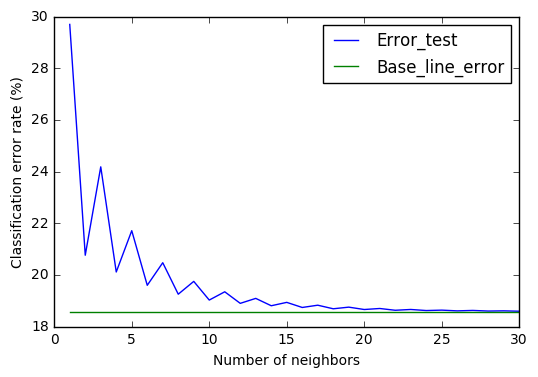

In [14]:
# Estimate model parameters using cross validation, inspired by [5].

# Maximum number of neighbors [1, 25]
K_range = range(1, 30 + 1)
# K-fold crossvalidation
K_fold = 10
N = knn_dtree_dict['N']
CV = cross_validation.KFold(N, K_fold, shuffle = False)
knn_dtree_dict['cv'] = {}
# Error matrix
errors = np.zeros((N, len(K_range)))
errors_base_line = np.zeros((N, len(K_range)))
i = 0
# Loop each fold
for train_index, test_index in CV:
    print 'Crossvalidation fold: {0}/{1}'.format(i + 1, CV.n_folds)
    # Extract training and test set for current CV fold
    X_train = knn_dtree_dict['X'][train_index,:]
    y_train = knn_dtree_dict['y'][train_index]
    X_test = knn_dtree_dict['X'][test_index,:]
    y_test = knn_dtree_dict['y'][test_index]
    knn_dtree_dict['cv'][i+1] = {}
    knn_dtree_dict['cv'][i+1]['train_idx'] = train_index
    knn_dtree_dict['cv'][i+1]['test_idx'] = test_index
    
    # Fit classifier and classify the test points (consider 1 to 40 neighbors)
    for k in K_range:
        # Fit
        knclassifier = neighbors.KNeighborsClassifier(n_neighbors = k);
        knclassifier.fit(X_train, y_train);
        # Classify
        y_est = knclassifier.predict(X_test);
        # Count errors
        errors[i, k - 1] = np.sum(y_est != y_test)
        # Find base line prediction and error
        base_line_pre = np.argmax(collections.Counter(y_test).values())
        errors_base_line[i, k - 1] = np.sum(base_line_pre != y_test)
    # End loop
    i +=1
# End loop

# Plot the classification error rate
plt.plot(range(1,errors.shape[1] + 1), (100 * np.mean(errors,axis=0)).tolist())
plt.plot(range(1,errors_base_line.shape[1] + 1), (100 * np.mean(errors_base_line,axis=0)).tolist())
plt.xlabel('Number of neighbors')
plt.ylabel('Classification error rate (%)')
plt.legend(['Error_test','Base_line_error'])
plt.show()

The plot above shows the classification error of the KNN and the base line estimate. Those two errors converges just below 19%. Remember the non injured nor killed class represents roughly 80% of the total observations.

Selecting the lowest possible number of K which has a sufficent low error will be around 10-14 neighbours. 

Next we will use K = 10 and fit the KNN on the last fold. Create random samples and predict the classes.

In [15]:
# Fitting KKN on randomly samples
# Selecting optimal K value..
knn_dtree_dict['k_opt'] = 10
# Crate KNN object
knn_dtree_dict['knn_opt_fit'] = neighbors.KNeighborsClassifier(n_neighbors = knn_dtree_dict['k_opt']);
# Fit KNN object using the train data from last fold in the code block before
knn_dtree_dict['knn_opt_fit'].fit(X_train, y_train);

# Geo limits
lat_min, lat_max = np.min(knn_dtree_dict['lat']), np.max(knn_dtree_dict['lat'])
lon_min, lon_max = np.min(knn_dtree_dict['lon']), np.max(knn_dtree_dict['lon'])

# Create randomly smapled predictions
N_pre = 10000 
import random
pre_X = np.array([[random.uniform(lat_min,lat_max), 
                   random.uniform(lon_min,lon_max), 
                   random.uniform(0,24), 
                   random.randint(1,12)] for ii in range(N_pre)])

# Classify based upon 
y_est = knn_dtree_dict['knn_opt_fit'].predict(pre_X);

#
knn_pre_json = [{'lat': pre_X[ii][0], 'lon': pre_X[ii][1],
                 'class': y_est[ii]} for ii in range(N_pre)]
# Create json with predictions
createJSON(knn_pre_json, 'data/knn/knn_pre_json.json') 

# Count predictions
tmp = collections.Counter(y_est)
# List for legends
knn_pre_json_leg = []
knn_pre_json_leg.append({'name': 'Total predictions: ' + str(N_pre), 'col': 'none'})

# Prints classification and append legends
if 0 in tmp.keys():
    print 'Non injured nor killed: {0:.3f}% ~ {1}'.format(tmp[0] / np.sum(tmp.values()) * 100, tmp[0])
    knn_pre_json_leg.append({'name': 'Non injured nor killed: ' + '{0:.3f}%'.format(tmp[0] / np.sum(tmp.values()) * 100), 'col': 'blue'})
else: knn_pre_json_leg.append({'name': 'Non injured nor killed: 0.000%', 'col': 'blue'})   
#
if 1 in tmp.keys():
    print 'Injured:                {0:.3f}% ~ {1}'.format(tmp[1] / np.sum(tmp.values()) * 100, tmp[1])
    knn_pre_json_leg.append({'name': 'Injured: ' + '{0:.3f}%'.format(tmp[1] / np.sum(tmp.values()) * 100), 'col': 'green'})
else:
    knn_pre_json_leg.append({'name': 'Injured: ' + '0.000%', 'col': 'green'})
#
if 2 in tmp.keys():
    print 'Killed:                 {0:.3f}% ~ {1}'.format(tmp[2] / np.sum(tmp.values()) * 100, tmp[2])
    knn_pre_json_leg.append({'name': 'Killed: ' + '{0:.3f}%'.format(tmp[2] / np.sum(tmp.values()) * 100), 'red': 'green'})
else:
    knn_pre_json_leg.append({'name': 'Killed: ' + '0.000%', 'col': 'red'})
#
if 3 in tmp.keys():
    print 'Injured and killed:     {0:.3f}% ~ {1}'.format(tmp[3] / np.sum(tmp.values()) * 100, tmp[3])
    knn_pre_json_leg.append({'name': 'Injured and killed: ' + '{0:.3f}%'.format(tmp[3] / np.sum(tmp.values()) * 100), 'black': 'green'})
else:
    knn_pre_json_leg.append({'name': 'Injured and killed: ' + '0.000%', 'col': 'black'})

# Create json with legends
createJSON(knn_pre_json_leg, 'data/knn/knn_pre_leg_json.json') 

Non injured nor killed: 99.250% ~ 9925
Injured:                0.750% ~ 75


As the above prints shows, the KNN predicts the classes as the base line prediction. 
An appropiate resampling approach of the minority classes could improve the KNN method.

### Decision Tree
The second machine learning algorithm is the decision tree. This algorithm will be train on same data and evaluated in the same way as the KNN algorithm.

The upper limit of the complexity of the tree will be set to 70.

Crossvalidation fold: 1/10
Crossvalidation fold: 2/10
Crossvalidation fold: 3/10
Crossvalidation fold: 4/10
Crossvalidation fold: 5/10
Crossvalidation fold: 6/10
Crossvalidation fold: 7/10
Crossvalidation fold: 8/10
Crossvalidation fold: 9/10
Crossvalidation fold: 10/10


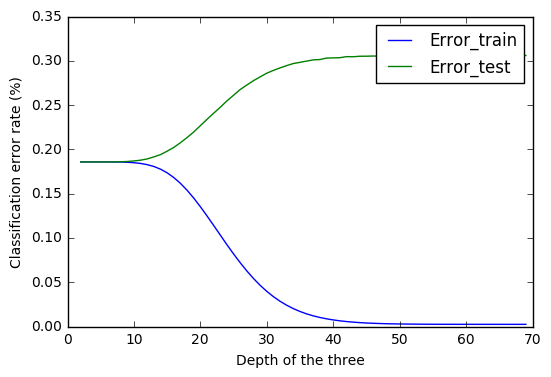

In [16]:
# exercise 6.1.2
# Estimate model parameters using cross validation, inspired by [5].
#print "Features: ", knn_dtree_dict['features']
knn_dtree_dict['target_names'] = ['Non injured nor killed','Injured','Killed','Injured and killed']
#print "Target: ", knn_dtree_dict['target_names']

# Tree complexity parameter - constraint on maximum depth
tc = np.arange(2, 70, 1)
# error arrays
Error_train = np.empty((len(tc),K_fold))
Error_test = np.empty((len(tc),K_fold))
k = 0
# K-fold crossvalidation
for train_index, test_index in CV:
    print 'Crossvalidation fold: {0}/{1}'.format(k + 1, K_fold)
    
    # Extract training and test set for current CV fold
    X_train = knn_dtree_dict['X'][knn_dtree_dict['cv'][k + 1]['train_idx'],:]
    y_train = knn_dtree_dict['y'][knn_dtree_dict['cv'][k + 1]['train_idx']]
    X_test = knn_dtree_dict['X'][knn_dtree_dict['cv'][k + 1]['test_idx'],:]
    y_test = knn_dtree_dict['y'][knn_dtree_dict['cv'][k + 1]['test_idx']]
    
    # Pruning aka. max_depth
    for i, t in enumerate(tc):
        # Fit decision tree classifier, Gini split criterion, different pruning levels (t)
        dtc = tree.DecisionTreeClassifier(criterion='gini', max_depth = t)
        dtc = dtc.fit(X_train, y_train)
        # Estimate errors
        y_est_test = dtc.predict(X_test)
        y_est_train = dtc.predict(X_train)
        # Evaluate misclassification rate over train/test data (in this CV fold)
        Error_test[i, k] = np.sum(y_est_test != y_test) / len(y_test)
        Error_train[i, k] = np.sum(y_est_train != y_train) / len(y_train)
    # End loop
    k+=1

# Plot the classification error rate
plt.plot(tc, np.mean(Error_train,axis=1))
plt.plot(tc, np.mean(Error_test,axis=1))
plt.xlabel('Depth of the three')
plt.ylabel('Classification error rate (%)')
plt.legend(['Error_train','Error_test'])
plt.show()

There is a trade off between classification error on train and test data. As the depth of the tree increases the complexity is growing. 
As the complexity increases the classification error of the training data is decreasing and the classification error of the test data is increasing due to over fitting. In other words the tree will be fitted to the noise from the training data. 

We want to have as low train and test error as possible, that is tricky part. In next code block the max depth of the tree will be 18.

Nex we try to fit it on the prediction data.

In [17]:
# Optimal values
tt_opt = 18 # it was 18 last time
dtc = tree.DecisionTreeClassifier(criterion='gini', max_depth = tt_opt)
# Fit the tree
dtc = dtc.fit(X_train, y_train)
# Predict classes
y_est = dtc.predict(pre_X)

# Count predictions
tmp = collections.Counter(y_est)
# Prints classification
if 0 in tmp.keys():
    print 'Non injured nor killed: {0:.3f}% ~ {1}'.format(tmp[0] / np.sum(tmp.values()) * 100, tmp[0])
#
if 1 in tmp.keys():
    print 'Injured:                {0:.3f}% ~ {1}'.format(tmp[1] / np.sum(tmp.values()) * 100, tmp[1])
#
if 2 in tmp.keys():
    print 'Killed:                 {0:.3f}% ~ {1}'.format(tmp[2] / np.sum(tmp.values()) * 100, tmp[2])
#
if 3 in tmp.keys():
    print 'Injured and killed:     {0:.3f}% ~ {1}'.format(tmp[3] / np.sum(tmp.values()) * 100, tmp[3])


Non injured nor killed: 83.920% ~ 8392
Injured:                15.920% ~ 1592
Killed:                 0.110% ~ 11
Injured and killed:     0.050% ~ 5


As the above prints shows, the decision tree is much better to handle non-balanced data.

The code block below is made for creation of the D3 decision tree plot.

In [18]:
# For plotting Getting
t = [2,tt_opt]
for tt in t:
    print 'TT: ', tt
    dtc = tree.DecisionTreeClassifier(criterion='gini', max_depth = tt)
    # dtc = dtc.fit(knn_dtree_dict['X'], knn_dtree_dict['y'])
    dtc = dtc.fit(X_train, y_train)
    # Estimate 
    y_est = dtc.predict(pre_X)
    # create D3 tree
    dtree_json = rules(dtc, knn_dtree_dict['features'], knn_dtree_dict['target_names'])
    createJSON(dtree_json, 'data/dtree/dtree_json_' + str(tt) + '.json')
    
    # print weigths
    createJSON([{'name': knn_dtree_dict['features'][ii] +': {0:3f}'.format(dtc.feature_importances_[ii]),'col': 'none'} for ii in range(len(knn_dtree_dict['features']))], 
           'data/dtree/dtree_pre_weg_json'+str(tt)+'.json')
    
    # Count predictions
    tmp = collections.Counter(y_est)
    # List for legends
    dtree_pre_json_leg = []
    dtree_pre_json_leg.append({'name': 'Total predictions: ' + str(N_pre), 'col': 'none'})
    # Prints classification and append legends
    if 0 in tmp.keys():
        print 'Non injured nor killed: {0:.3f}% ~ {1}'.format(tmp[0] / np.sum(tmp.values()) * 100, tmp[0])
        dtree_pre_json_leg.append({'name': 'Non injured nor killed: ' + '{0:.3f}%'.format(tmp[0] / np.sum(tmp.values()) * 100), 'col': 'blue'})
    else: dtree_pre_json_leg.append({'name': 'Non injured nor killed: 0.000%', 'col': 'blue'})   
    #
    if 1 in tmp.keys():
        print 'Injured:                {0:.3f}% ~ {1}'.format(tmp[1] / np.sum(tmp.values()) * 100, tmp[1])
        dtree_pre_json_leg.append({'name': 'Injured: ' + '{0:.3f}%'.format(tmp[1] / np.sum(tmp.values()) * 100), 'col': 'green'})
    else:
        dtree_pre_json_leg.append({'name': 'Injured: ' + '0.000%', 'col': 'green'})
    #
    if 2 in tmp.keys():
        print 'Killed:                 {0:.3f}% ~ {1}'.format(tmp[2] / np.sum(tmp.values()) * 100, tmp[2])
        dtree_pre_json_leg.append({'name': 'Killed: ' + '{0:.3f}%'.format(tmp[2] / np.sum(tmp.values()) * 100), 'red': 'green'})
    else:
        dtree_pre_json_leg.append({'name': 'Killed: ' + '0.000%', 'col': 'red'})
    #
    if 3 in tmp.keys():
        print 'Injured and killed:     {0:.3f}% ~ {1}'.format(tmp[3] / np.sum(tmp.values()) * 100, tmp[3])
        dtree_pre_json_leg.append({'name': 'Injured and killed: ' + '{0:.3f}%'.format(tmp[3] / np.sum(tmp.values()) * 100), 'black': 'green'})
    else:
        dtree_pre_json_leg.append({'name': 'Injured and killed: ' + '0.000%', 'col': 'black'})

    # Create json with legends
    createJSON(dtree_pre_json_leg, 'data/dtree/dtree_pre_leg_json'+str(tt)+'.json') 



TT:  2
Non injured nor killed: 100.000% ~ 10000
TT:  18
Non injured nor killed: 81.880% ~ 8188
Injured:                17.970% ~ 1797
Killed:                 0.100% ~ 10
Injured and killed:     0.050% ~ 5


### Weather correlation

In [19]:
raw_weather_DF = pd.read_csv("data/raw_data_weather.csv", low_memory = False)

# Extracting interesting features
raw_weather_DF = raw_weather_DF[['DATE', 'PRCP','SNOW', 'SNWD','TMIN', 'TMAX']]

# Changing date format
date = raw_weather_DF["DATE"].apply(lambda x: [str(x)[4:6],str(x)[6:8],str(x)[:4]])
raw_weather_DF["YEAR"] = date.apply(lambda x: int(x[2]))
raw_weather_DF["DATE"] = date.apply(lambda x: x[0]+'/'+x[1]+'/'+x[2])

# -9999.0 -> Nan
raw_weather_DF = raw_weather_DF[raw_weather_DF != -9999.0] 

In [20]:
# Counting for each day
unq_weather_day = list(set(raw_weather_DF['DATE']))
unq_day = list(pra_info['unique days'])
# unique days sorted
unq_weather_day.sort(key=lambda x: dt.datetime.strptime(x, '%m/%d/%Y'))
unq_day.sort(key=lambda x: dt.datetime.strptime(x, '%m/%d/%Y'))
# init dict
weather_dict = {}
# Loop each day
for dd in unq_day:
    weather_dict[dd] = {}
    # weather data
    tmp_idx = list(raw_weather_DF[(raw_weather_DF['DATE'] == dd)].index)
    # average rain, snow, snow depth, min and max temperature
    tmp = np.nanmean(raw_weather_DF[['PRCP','SNOW', 'SNWD','TMIN', 'TMAX']].iloc[tmp_idx], axis=0)
    weather_dict[dd]['PRCP'] = tmp[0]
    weather_dict[dd]['SNOW'] = tmp[1]
    weather_dict[dd]['SNWD'] = tmp[2]
    weather_dict[dd]['TMIN'] = tmp[3]
    weather_dict[dd]['TMAX'] = tmp[4]
        
    # accidents data data
    tmp_idx = list(raw_DF[(raw_DF['DATE'] == dd)].index)
    #
    tmp = np.nansum(raw_DF[['NUMBER OF PEDESTRIANS INJURED','NUMBER OF PEDESTRIANS KILLED',
                            'NUMBER OF CYCLIST INJURED','NUMBER OF CYCLIST KILLED',
                            'NUMBER OF MOTORIST INJURED','NUMBER OF MOTORIST KILLED']].iloc[tmp_idx], axis=0)
    #
    weather_dict[dd]['NUMBER OF PEDESTRIANS INJURED'] = tmp[0]
    weather_dict[dd]['NUMBER OF PEDESTRIANS KILLED'] = tmp[1]
    weather_dict[dd]['NUMBER OF CYCLIST INJURED'] = tmp[2]
    weather_dict[dd]['NUMBER OF CYCLIST KILLED'] = tmp[3]
    weather_dict[dd]['NUMBER OF MOTORIST INJURED'] = tmp[4]
    weather_dict[dd]['NUMBER OF MOTORIST KILLED'] = tmp[5]
# end loop

In [21]:
# dictionary to pandas and then normalizing
rwDF_norm = pd.DataFrame.from_dict(weather_dict, orient='columns').transpose()
rwDF_norm['PRCP'] = (rwDF_norm['PRCP'] - np.min(rwDF_norm['PRCP'])) / (np.max(rwDF_norm['PRCP']) - np.min(rwDF_norm['PRCP']))
rwDF_norm['SNOW'] = (rwDF_norm['SNOW'] - np.min(rwDF_norm['SNOW'])) / (np.max(rwDF_norm['SNOW']) - np.min(rwDF_norm['SNOW']))
rwDF_norm['SNWD'] = (rwDF_norm['SNWD'] - np.min(rwDF_norm['SNWD'])) / (np.max(rwDF_norm['SNWD']) - np.min(rwDF_norm['SNWD']))
rwDF_norm['TMIN'] = (rwDF_norm['TMIN'] - np.min(rwDF_norm['TMIN'])) / (np.max(rwDF_norm['TMIN']) - np.min(rwDF_norm['TMIN']))
rwDF_norm['TMAX'] = (rwDF_norm['TMAX'] - np.min(rwDF_norm['TMAX'])) / (np.max(rwDF_norm['TMAX']) - np.min(rwDF_norm['TMAX']))

rwDF_norm['NUMBER OF CYCLIST INJURED'] = ((rwDF_norm['NUMBER OF CYCLIST INJURED'] - np.min(rwDF_norm['NUMBER OF CYCLIST INJURED'])) / 
                                       (np.max(rwDF_norm['NUMBER OF CYCLIST INJURED']) - np.min(rwDF_norm['NUMBER OF CYCLIST INJURED'])))
rwDF_norm['NUMBER OF CYCLIST KILLED'] = ((rwDF_norm['NUMBER OF CYCLIST KILLED'] - np.min(rwDF_norm['NUMBER OF CYCLIST KILLED'])) / 
                  (np.max(rwDF_norm['NUMBER OF CYCLIST KILLED']) - np.min(rwDF_norm['NUMBER OF CYCLIST KILLED'])))

rwDF_norm['NUMBER OF MOTORIST INJURED'] = ((rwDF_norm['NUMBER OF MOTORIST INJURED'] - np.min(rwDF_norm['NUMBER OF MOTORIST INJURED'])) / 
                                       (np.max(rwDF_norm['NUMBER OF MOTORIST INJURED']) - np.min(rwDF_norm['NUMBER OF MOTORIST INJURED'])))
rwDF_norm['NUMBER OF MOTORIST KILLED'] = ((rwDF_norm['NUMBER OF MOTORIST KILLED'] - np.min(rwDF_norm['NUMBER OF MOTORIST KILLED'])) / 
                  (np.max(rwDF_norm['NUMBER OF MOTORIST KILLED']) - np.min(rwDF_norm['NUMBER OF MOTORIST KILLED'])))

rwDF_norm['NUMBER OF PEDESTRIANS INJURED'] = ((rwDF_norm['NUMBER OF PEDESTRIANS INJURED'] - np.min(rwDF_norm['NUMBER OF PEDESTRIANS INJURED'])) / 
                                       (np.max(rwDF_norm['NUMBER OF PEDESTRIANS INJURED']) - np.min(rwDF_norm['NUMBER OF PEDESTRIANS INJURED'])))
rwDF_norm['NUMBER OF PEDESTRIANS KILLED'] = ((rwDF_norm['NUMBER OF PEDESTRIANS KILLED'] - np.min(rwDF_norm['NUMBER OF PEDESTRIANS KILLED'])) / 
                  (np.max(rwDF_norm['NUMBER OF PEDESTRIANS KILLED']) - np.min(rwDF_norm['NUMBER OF PEDESTRIANS KILLED'])))

In [22]:
# Determine the correlations coefficents
arr_corr = np.corrcoef(rwDF_norm.transpose())
attr_list =['x1','x2','x3','x4','x5','x6','PRCP','SNOW','SNWD','TMAX','TMIN']

# highest and lowest correlations
tmp = np.array(list(set(sorted(np.abs(arr_corr.ravel().tolist())))))
print "Highest: ", tmp[(-tmp).argsort()[:2]][1]
print "Lowest:  ", tmp[(tmp).argsort()[:1]][0]

# see table on web page or below
#print 'np corr table:\n',arr_corr
#print 'HTML corr table:\n', pd.DataFrame(arr_corr, index=attr_list, columns=attr_list).to_html()

Highest:  0.967119773114
Lowest:   0.00116827957631


The table below is correlation matrix containing six feature from the NYPD MVC data set and five features from the NOAA data set. 
All weather phonemes have been averages for each unique day and the accidents have been summed for each unique day. Afterwards each series have been normalized in order to calculate the correlation matrix showed below. 

The highest correlations coefficients is between:
- TMAX and TMIN = 0.967120
This one make sense because of the nature of law. 

The lowest correlations coefficients is between:
- NUMBER OF CYCLIST KILLED and NUMBER OF PEDESTRIANS INJURED = 0.001168

The highest correlations coefficients between weather phonemes and accidents are:
- NUMBER OF CYCLIST INJURED and TMIN = 0.571137
- NUMBER OF CYCLIST INJURED and TMAX = 0.598722

It also make sense as an increasing in temperatur motivates for biking instead of the subway.

Despite the above observations there seems not to be strong coorelation which can be used to act upon in order to decrease the number of accidents.

## 5. Discussion
- What went well:
    - The NYPD increase the focus in the winter month as the yearly seasonality shows above. This methods is a quick methods to find the season and trend within the data.
    - The KNN methods did not as good as the decision tree. But it possible to use the decision tree as a prediction tool for future accident calls. But remember the accident could be an anomaly and hereby not match the predicted type of accident.
    - The visualizations in the web page are responding well. It has to load roughly 18 MB which is done in 12 seconds on this computer.
    - A personal good learning process wihtin the D3, js and html in this project. And been challenged on all the visualization aspects.
- Improvements:
    - It could be to nice have an anomaly detection algorithm, which can support the seasonality algorithm. A suitable choise will be [AnomalyDetection](https://github.com/twitter/AnomalyDetection.git) provided by Twitter.
    - The possiblity to zoom in the time series plot and in the decision tree will increase the level to detail and more information could be obtained.
    - If there was more time, the bar plots will be normalized insted. Then it will be easier to compare the the actual time slots. 
    - Finding a solution so the heat-map can contain every accidents and not overfloat.
    - Create a new map with the predicted classes from the decision tree. Then it is possible to visual compare the decision tree and the KNN algorithm.
    - Find a solution to the different types of screen. There may be a better bootstrap tampleate out there. 
    - creating a loading symbol so the user know what is going when the web page does not respond.
    - Try different types of tree algorithms. Maybe an [isolation forest algorithm](https://cs.nju.edu.cn/zhouzh/zhouzh.files/publication/icdm08b.pdf). This algorithm can also be used for furhter anomaly detection as well.
    - Implement a logistic regression model and see how it works on the im-balanced classes.
    - Try to solve the challenge with im-balanced classes by using an appropriate resampling method. 
    - Find taxi data information and use this as an estimation of the density of the total traffic in New York City.

## 6. References
[1] Start Bootstrap, Scrolling Nav, [url](https://github.com/BlackrockDigital/startbootstrap-scrolling-nav) (visited on 6/5-2017).

[2] Aaron Schumacher, See sklearn trees with D3, [url](http://planspace.org/20151129-see_sklearn_trees_with_d3/) (visited on 6/5-2017).

[3] NYC GOV, [url](http://www.nyc.gov/html/dot/summerstreets/html/home/home.shtml) (visited on 6/5-2017).

[4] NYPD MVC Data, [url](https://data.cityofnewyork.us/Public-Safety/NYPD-Motor-Vehicle-Collisions/h9gi-nx95/data) (visited on 6/5-2017).

[5] DTU Course 02450, Toolbox.

[6] NOAA, Climate Data Online, [url](https://www.ncdc.noaa.gov/cdo-web/) (visited on 6/5-2017).

[7] NOAA, Data sheet, [url](https://www1.ncdc.noaa.gov/pub/data/cdo/documentation/GHCND_documentation.pdf) (visited on 6/5-2017).